# Imports

In [20]:
!pip install -U -q PyDrive

import os, shutil
from os import path
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import zipfile
import keras
import tensorflow as tf
from keras import models 
from keras import layers
from keras import optimizers
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd 
import scipy.io
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.metrics import classification_report, confusion_matrix
from keras.preprocessing import image
from keras import backend as K
from IPython.display import Image, display

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold
from PIL import Image
from PIL import ImageFile
import random

# Set a random seed
from numpy.random import seed
seed(1)

# Download Data

In [2]:
#Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
#Choose a local (colab) directory to store the data.
local_download_path = os.path.expanduser('~/data')
try:
  os.makedirs(local_download_path)
except: pass

#Auto-iterate using the query syntax
file_list = drive.ListFile(
    {'q': "'1tQbRH3uO-mwTbViQTNdzs_4x-UnUkoSz' in parents"}).GetList()

for f in file_list:
  #Create & download by id.
  print('title: %s, id: %s' % (f['title'], f['id']))
  fname = os.path.join(local_download_path, f['title'])
  print('downloading to {}'.format(fname))
  f_ = drive.CreateFile({'id': f['id']})
  f_.GetContentFile(fname)
  break

title: DataSet.zip, id: 1BeacQpDbIvJCk93KrpJxxsoeAcS_8ySo
downloading to /root/data/DataSet.zip


In [4]:
with zipfile.ZipFile('/root/data/DataSet.zip', 'r') as zip_ref:
    zip_ref.extractall('/root/data')

# Data Preprocessing

In [ ]:
#Code used to reorganize the data in to new splits

# #Move all data to the same folders

# #Destination folders
# dst_normal = 'C:/Users/Eurico/Documents/DeepLearning/secondTheme/chest_xray/AllData/NORMAL'
# dst_pneumonia = 'C:/Users/Eurico/Documents/DeepLearning/secondTheme/chest_xray/AllData/PNEUMONIA'

# #Original folders
# src_normal = ['C:/Users/Eurico/Documents/DeepLearning/secondTheme/chest_xray/val/NORMAL',
#              'C:/Users/Eurico/Documents/DeepLearning/secondTheme/chest_xray/test/NORMAL',
#              'C:/Users/Eurico/Documents/DeepLearning/secondTheme/chest_xray/train/NORMAL']

# src_pneumonia = ['C:/Users/Eurico/Documents/DeepLearning/secondTheme/chest_xray/val/PNEUMONIA',
#              'C:/Users/Eurico/Documents/DeepLearning/secondTheme/chest_xray/test/PNEUMONIA',
#              'C:/Users/Eurico/Documents/DeepLearning/secondTheme/chest_xray/train/PNEUMONIA']

# #Loop to copy data from original folders to destination folders
# for j in src_normal:
#     files = [i for i in os.listdir(j)]
#     for f in files:
#         shutil.copy(path.join(j, f), dst_normal)
        
# for j in src_pneumonia:
#     files = [i for i in os.listdir(j)]
#     for f in files:
#         shutil.copy(path.join(j, f), dst_pneumonia)

# #Create train, val, test split (70, 15, 15)

# #Destination folders
# dst_normal = ['C:/Users/Eurico/Documents/DeepLearning/secondTheme/chest_xray/DataSet/train/NORMAL',
#              'C:/Users/Eurico/Documents/DeepLearning/secondTheme/chest_xray/DataSet/val/NORMAL',
#              'C:/Users/Eurico/Documents/DeepLearning/secondTheme/chest_xray/DataSet/test/NORMAL']

# dst_pneumonia = ['C:/Users/Eurico/Documents/DeepLearning/secondTheme/chest_xray/DataSet/train/PNEUMONIA',
#              'C:/Users/Eurico/Documents/DeepLearning/secondTheme/chest_xray/DataSet/val/PNEUMONIA',
#              'C:/Users/Eurico/Documents/DeepLearning/secondTheme/chest_xray/DataSet/test/PNEUMONIA']

# #Source folders
# src_normal = 'C:/Users/Eurico/Documents/DeepLearning/secondTheme/chest_xray/AllData/NORMAL'
# src_pneumonia = 'C:/Users/Eurico/Documents/DeepLearning/secondTheme/chest_xray/AllData/PNEUMONIA'

# #Files (images) in source folders
# files_normal = [i for i in os.listdir(src_normal)]
# files_pneumonia = [i for i in os.listdir(src_pneumonia)]

# #Counters
# count_normal = 1
# count_pneumonia = 1

# #Loops to copy images to destination folders
# for f in files_normal:
#     if count_normal <= 1108:
#         shutil.copy(path.join(src_normal, f), dst_normal[0]) 
#     elif count_normal <= (1108+238):
#         shutil.copy(path.join(src_normal, f), dst_normal[1])
#     else:
#         shutil.copy(path.join(src_normal, f), dst_normal[2])
#     count_normal = count_normal + 1
    
# for f in files_pneumonia:
#     if count_pneumonia <= 2993:
#         shutil.copy(path.join(src_pneumonia, f), dst_pneumonia[0]) 
#     elif count_pneumonia <= (2993+640):
#         shutil.copy(path.join(src_pneumonia, f), dst_pneumonia[1])
#     else:
#         shutil.copy(path.join(src_pneumonia, f), dst_pneumonia[2])
#     count_pneumonia = count_pneumonia + 1

In [ ]:
#Code used to produce oversampling dataset trough data augmentation

#Data augmentation used
# train_augment_datagen = ImageDataGenerator(rescale = 1./255,
#                                   rotation_range=40,
#                                   width_shift_range=0.2,
#                                   height_shift_range=0.2,
#                                   shear_range=0.2,
#                                   zoom_range=0.2,
#                                   fill_mode='nearest')

# train_augment_set = train_augment_datagen.flow_from_directory('C:/Users/Eurico/Documents/DeepLearning/secondTheme/chest_xray/DataSet/train/', 
#                                                  target_size = (75, 75),
#                                                  batch_size = 20,
#                                                  class_mode = 'binary',
                                                 
#                                                 )

# count = 1

# for images, labels in train_augment_set:
#     for i in range(20):
#         if labels[i] == 0: #If the data augmented image is of the minority label, save itt
#             matplotlib.image.imsave('C:/Users/Eurico/Documents/DeepLearning/secondTheme/chest_xray/DataSet_DataAugOversampling/train/NORMAL/augmented'+str(count)+'.jpeg', images[i])
#             count = count + 1
#             if count >= 1885: #When the desired number of images are created aand saved, stop the loop
#                 break
#     if count >= 1885:
#         break

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255)

#Generator for augmented data
train_augment_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale = 1./255)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
train_set = train_datagen.flow_from_directory('/root/data/DataSet/train/', 
                                                 target_size = (75, 75),
                                                 batch_size = 20,
                                                 class_mode = 'binary',
                                                 seed=1
                                                )

train_augment_set = train_augment_datagen.flow_from_directory('/root/data/DataSet/train/', 
                                                 target_size = (75, 75),
                                                 batch_size = 20,
                                                 class_mode = 'binary',
                                                 seed=1
                                                )
#To be used for the confusion matrix
val_set = val_datagen.flow_from_directory('/root/data/DataSet/val/', 
                                            target_size = (75, 75),
                                            batch_size = 20,
                                            class_mode = 'binary',
                                            seed=1
                                           )

val_set_cm = val_datagen.flow_from_directory('/root/data/DataSet/val/', 
                                            target_size = (75, 75),
                                            batch_size = 1,
                                            class_mode = 'binary',
                                            seed=1,
                                            shuffle=False
                                           )

test_set = test_datagen.flow_from_directory('/root/data/DataSet/test/', 
                                            target_size = (75, 75),
                                            batch_size = 20,
                                            class_mode = 'binary',
                                            seed=1,
                                            shuffle = False
                                           )

Found 4101 images belonging to 2 classes.
Found 878 images belonging to 2 classes.
Found 878 images belonging to 2 classes.
Found 877 images belonging to 2 classes.


# Tensorboard

In [ ]:
#Create log directory
!mkdir /root/data/logs

#Load tensorboard
%load_ext tensorboard

#Launch tensorboard
%tensorboard --logdir /root/data/logs

In [ ]:
#Used when running a second model

#Delete log folder
#!rm -rf /root/data/logs

# Model Creation and Training

In [ ]:
callbacks_list= [keras.callbacks.TensorBoard(log_dir='/root/data/logs', histogram_freq=1),
                 keras.callbacks.EarlyStopping(monitor = 'acc', patience=3), 
                 keras.callbacks.ModelCheckpoint(filepath="/root/data/DataSet/my_model.h5", monitor ="val_loss", save_best_only=True)]

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(16, (3,3), activation='relu', input_shape=(75,75,3)))
model.add(layers.Conv2D(32, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2), strides=2))
model.add(layers.Conv2D(32, (3,3), activation='relu'))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2), strides=2))
model.add(layers.Flatten())
#model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001), activation='relu'))
#model.add(layers.Dense(512, kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001), activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['acc'])

In [ ]:
#model = models.load_model('/root/data/ReducedInputSizeModel.h5')

In [ ]:
hist= model.fit(
        train_set,
        steps_per_epoch= 205,
        epochs= 50,
        validation_data=val_set,
        validation_steps=43, 
        callbacks=callbacks_list
        )

Epoch 1/50
205/205 [==============================] - 111s 536ms/step - loss: 11.7620 - acc: 0.7438 - val_loss: 1.5384 - val_acc: 0.8837
Epoch 2/50
205/205 [==============================] - 108s 524ms/step - loss: 1.4156 - acc: 0.8301 - val_loss: 1.0218 - val_acc: 0.8593
Epoch 3/50
205/205 [==============================] - 108s 528ms/step - loss: 0.9028 - acc: 0.8774 - val_loss: 0.6350 - val_acc: 0.9605
Epoch 4/50
205/205 [==============================] - 107s 521ms/step - loss: 0.6956 - acc: 0.8891 - val_loss: 0.7033 - val_acc: 0.8407
Epoch 5/50
205/205 [==============================] - 101s 492ms/step - loss: 0.5950 - acc: 0.9029 - val_loss: 0.4902 - val_acc: 0.9198
Epoch 6/50
205/205 [==============================] - 101s 492ms/step - loss: 0.5290 - acc: 0.9039 - val_loss: 0.3874 - val_acc: 0.9605
Epoch 7/50
205/205 [==============================] - 101s 492ms/step - loss: 0.4804 - acc: 0.9103 - val_loss: 0.3640 - val_acc: 0.9674
Epoch 8/50
205/205 [===========================

# Model Assessment

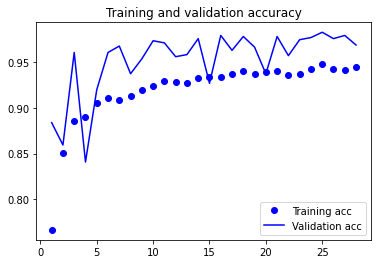

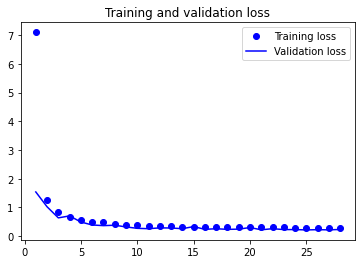

In [ ]:
acc = hist.history['acc']
val_acc = hist.history['val_acc']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
#model.save('/root/data/ReducedInputSizeModel.h5')

In [ ]:
Y_pred = model.predict(val_set_cm,878) # ceil(num_of_test_samples / batch_size)
Y_pred = (Y_pred>0.5)
print('Confusion Matrix')
print(confusion_matrix(val_set_cm.classes, Y_pred))
print('Classification Report')
target_names = ['PlaceHolder', 'PlaceHolder']
print(classification_report(val_set_cm.classes, Y_pred, target_names=target_names))

Confusion Matrix
[[234   4]
 [ 24 616]]
Classification Report
              precision    recall  f1-score   support

 PlaceHolder       0.91      0.98      0.94       238
 PlaceHolder       0.99      0.96      0.98       640

    accuracy                           0.97       878
   macro avg       0.95      0.97      0.96       878
weighted avg       0.97      0.97      0.97       878



# Grad-CAM

In [ ]:
img_path = 'C:/Users/Eurico/Documents/DeepLearning/secondTheme/chest_xray/DataSet/test/PNEUMONIA/person69_bacteria_338.jpeg'

img = image.load_img(img_path, target_size=(75,75))

x = image.img_to_array(img)

x = np.expand_dims(x, axis=0)

x = x/255

In [ ]:
#Taken from https://keras.io/examples/vision/grad_cam/

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
# Generate class activation heatmap
#heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

heatmap = make_gradcam_heatmap(x, model, 'conv2d_7')

# Display heatmap
plt.matshow(heatmap)
plt.show()

In [ ]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))

In [ ]:
save_and_display_gradcam(img_path, heatmap)

# K-fold Cross Validation

In [5]:
#Adapted from https://github.com/SadmanSakib93/Stratified-k-fold-cross-validation-Image-classification-keras

#Create folder for val partition of the training splits
!mkdir /root/data/DataSet/val_train_fold
!mkdir /root/data/DataSet/val_train_fold/NORMAL
!mkdir /root/data/DataSet/val_train_fold/PNEUMONIA

datasetFolderName='/root/data/DataSet'
sourceFiles=[]
classLabels=['NORMAL', 'PNEUMONIA']

In [24]:
#Adapted from https://github.com/SadmanSakib93/Stratified-k-fold-cross-validation-Image-classification-keras

def transferBetweenFolders(source, dest, splitRate):   
    global sourceFiles
    sourceFiles=os.listdir(source)
    if(len(sourceFiles)!=0):
        transferFileNumbers=int(len(sourceFiles)*splitRate)
        transferIndex=random.sample(range(0, len(sourceFiles)), transferFileNumbers)
        for eachIndex in transferIndex:
            shutil.move(source+str(sourceFiles[eachIndex]), dest+str(sourceFiles[eachIndex]))
    else:
        print("No file moved. Source empty!")
        
def transferAllClassBetweenFolders(source, dest, splitRate):
    for label in classLabels:
        transferBetweenFolders(datasetFolderName+'/'+source+'/'+label+'/', 
                               datasetFolderName+'/'+dest+'/'+label+'/', 
                               splitRate)
        
def my_metrics(y_true, y_pred):
    accuracy=accuracy_score(y_true, y_pred)
    precision=precision_score(y_true, y_pred)
    recall=recall_score(y_true, y_pred)
    f1Score=f1_score(y_true, y_pred) 
    print("Accuracy  : {}".format(accuracy))
    print("Precision : {}".format(precision))
    print("Recall : {}".format(recall))
    print("f1Score : {}".format(f1Score))
    cm=confusion_matrix(y_true, y_pred)
    print(cm)
    return accuracy, precision, recall, f1Score

In [7]:
#Adapted from https://github.com/SadmanSakib93/Stratified-k-fold-cross-validation-Image-classification-keras

X=[]
Y=[]

def prepareNameWithLabels(folderName):
    sourceFiles=os.listdir(datasetFolderName+'/train/'+folderName)
    for val in sourceFiles:
        X.append(val)
        if(folderName==classLabels[0]):
            Y.append(0)
        elif(folderName==classLabels[1]):
            Y.append(1)
       
# Organize file names and class labels in X and Y variables
prepareNameWithLabels(classLabels[0])
prepareNameWithLabels(classLabels[1])
      
X=np.asarray(X)
Y=np.asarray(Y)

# learning rate
batch_size = 20
epochs=25
activationFunction='relu'

def getModel():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(75,75,3)))
    model.add(layers.MaxPooling2D((2,2), strides=2))
    model.add(layers.Conv2D(64, (3,3), activation='relu'))
    model.add(layers.MaxPooling2D((2,2), strides=2))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['acc'])

    return model

# input image dimensions
img_rows, img_cols =  75, 75

train_path=datasetFolderName+'/train/'
validation_path=datasetFolderName+'/val_train_fold/'
model=getModel()
acc_avg=[]
prec_avg=[]
rec_avg=[]
f1_agv=[]
# ===============Stratified K-Fold======================
skf = StratifiedKFold(n_splits=3, shuffle=True)
skf.get_n_splits(X, Y)
foldNum=0
for train_index, val_index in skf.split(X, Y):
    #First cut all images from validation to train (if any exists)
    transferAllClassBetweenFolders('val_train_fold', 'train', 1.0)
    foldNum+=1
    print("Results for fold",foldNum)
    X_train, X_val = X[train_index], X[val_index]
    Y_train, Y_val = Y[train_index], Y[val_index]
    # Move validation images of this fold from train folder to the validation folder
    for eachIndex in range(len(X_val)):
        classLabel=''
        if(Y_val[eachIndex]==0):
            classLabel=classLabels[0]
        elif(Y_val[eachIndex]==1):
            classLabel=classLabels[1]
 
        #Then, copy the validation images to the validation folder
        shutil.move(datasetFolderName+'/train/'+classLabel+'/'+X_val[eachIndex], 
                    datasetFolderName+'/val_train_fold/'+classLabel+'/'+X_val[eachIndex])
        
    train_datagen_kf = ImageDataGenerator(
                       rescale=1./255,
                       )
    validation_datagen_kf = ImageDataGenerator(rescale=1./255)
        
    #Start ImageClassification Model
    train_generator_kf = train_datagen_kf.flow_from_directory(
                          train_path,
                          target_size=(img_rows, img_cols),
                          batch_size=batch_size,
                          class_mode='binary'
                          )

    validation_generator_kf = validation_datagen_kf.flow_from_directory(
                              validation_path,
                              target_size=(img_rows, img_cols),
                              batch_size=batch_size,
                              class_mode='binary' 
                              )  
    
    validation_generator_2 = validation_datagen_kf.flow_from_directory(
                             validation_path,
                             target_size=(img_rows, img_cols),
                             batch_size=1,
                             class_mode='binary',  # only data, no labels
                             shuffle=False)   
    
    # fit model
    callbacks_list= [keras.callbacks.EarlyStopping(monitor = 'acc', patience=5), 
                     keras.callbacks.ModelCheckpoint(filepath="/root/data/DataSet/my_model.h5", 
                                                      monitor ="val_loss", save_best_only=True)]
    model=getModel()

    history= model.fit(
        train_generator_kf,
        epochs= epochs,
        steps_per_epoch=len(train_index)//batch_size,
        validation_data=validation_generator_kf,
        validation_steps=len(val_index)//batch_size, 
        callbacks=callbacks_list
        )
    
    predictions = model.predict(validation_generator_2,len(val_index)) # ceil(num_of_test_samples / batch_size)
    yPredictions = (predictions>0.5)
    true_classes = validation_generator_2.classes
    # evaluate validation performance
    print("***Performance on Validation data***")    
    valAcc, valPrec, valRec, valFScore = my_metrics(true_classes, yPredictions)
    acc_avg.append(valAcc)
    prec_avg.append(valPrec)
    rec_avg.append(valRec)
    f1_agv.append(valFScore)

#Place all of the training data back to the training folder
transferAllClassBetweenFolders('val_train_fold', 'train', 1.0)

#Delete folders we no longer need
!rm -rf /root/data/DataSet/val_train_fold/PNEUMONIA
!rm -rf /root/data/DataSet/val_train_fold/NORMAL
!rm -rf /root/data/DataSet/val_train_fold

No file moved. Source empty!
No file moved. Source empty!
Results for fold 1
Found 2734 images belonging to 2 classes.
Found 1367 images belonging to 2 classes.
Found 1367 images belonging to 2 classes.
Epoch 1/25
136/136 [==============================] - 76s 547ms/step - loss: 0.5901 - acc: 0.7399 - val_loss: 0.3529 - val_acc: 0.8184
Epoch 2/25
136/136 [==============================] - 74s 544ms/step - loss: 0.3432 - acc: 0.8563 - val_loss: 0.2858 - val_acc: 0.9140
Epoch 3/25
136/136 [==============================] - 72s 530ms/step - loss: 0.2737 - acc: 0.8892 - val_loss: 0.1933 - val_acc: 0.9301
Epoch 4/25
136/136 [==============================] - 72s 527ms/step - loss: 0.2223 - acc: 0.9168 - val_loss: 0.1703 - val_acc: 0.9346
Epoch 5/25
136/136 [==============================] - 73s 533ms/step - loss: 0.2059 - acc: 0.9211 - val_loss: 0.2168 - val_acc: 0.9206
Epoch 6/25
136/136 [==============================] - 72s 527ms/step - loss: 0.1755 - acc: 0.9353 - val_loss: 0.1524 - val

In [19]:
print('Metric----------Average---------StandardDeviation')
print('Accuracy: ',np.mean(acc_avg),np.std(acc_avg))
print('Precision:',np.mean(prec_avg),np.std(prec_avg))
print('Recall:   ',np.mean(rec_avg),np.std(rec_avg))
print('F1-score: ',np.mean(f1_agv),np.std(f1_agv))

Metric----------Average---------StandardDeviation
Accuracy:  0.9522067788344306 0.0032896214492153268
Precision: 0.9520060239327469 0.0031581225585723635
F1-score:  0.9517120535329942 0.0035540189339799727


In [25]:
my_metrics(true_classes, yPredictions)

Accuracy  : 0.9480614484272128
Precision : 0.9478260869565217
Recall : 0.9829659318637275
f1Score : 0.9650762420068864
[[315  54]
 [ 17 981]]


(0.9480614484272128,
 0.9478260869565217,
 0.9829659318637275,
 0.9650762420068864)